In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 500
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# fix all of our plot backgrounds
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [3]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/control_cohort2/'
h3k27acDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
workingDirectory = '/home/h1bennet/strains/results/06_Strains_Control_Cohort2_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


### Make output directory

In [5]:
if not os.path.isdir('./peak_heatmaps/'):
    os.mkdir('./peak_heatmaps/')

# Read in differential ATAC-seq data

In [6]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_idr_peaks_merged.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')

annotatePeaks all peaks (86301, 30)
getDiffExpression selected transcripts (84264, 39)
annotatePeaks selected peaks (84264, 30)


Pull intersection and union peaks

In [7]:
# initialize dict and list of cell types
peak_lists = {}
bg_lists = {}
cells = ['aj',
         'balbcj',
         'c57bl6j']

# set pvalue and fc thresholds
fc = np.log2(2)
pval = 0.05

for cell in cells:
    print('Analyzing', cell, '...\n')
    
    # set count
    count = 0
    
    for key in comp_dict.keys():
        
        # select get diff data frame.
        df = comp_dict[key]
        
        # check on counter
        print(count)


        # initialize lists if count == 0
        if count == 0:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = set(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        else:
            # fold change direction depends on the location of the cell in the comparison.
            # if cell is in first position it is reference - so negative log2fc is higher in first position
            if cell in key.split(' vs. ')[0]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] < -fc)])
                count = count + 1
            # if cell is in second position it is comparison - so positive log2fc is higher in second position
            elif cell in key.split(' vs. ')[1]:
                u = u.union(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                i = i.intersection(df.index[(df.loc[:, 'adj_pval'] <= pval) & (df.loc[:, 'log2fc'] > fc)])
                count = count + 1

        
        # summarize iteration
        print('For comp:', key)
        print('Union set at:', len(u), 'peaks')
        print('Intersection set at:', len(i), 'peaks\n')
     
    
        # store lists
        peak_lists[cell+'_union'] = u
        peak_lists[cell+'_intersection'] = i

Analyzing aj ...

0
For comp: aj vs. balbcj
Union set at: 1386 peaks
Intersection set at: 1386 peaks

1
For comp: aj vs. c57bl6j
Union set at: 3871 peaks
Intersection set at: 593 peaks

2
For comp: balbcj vs. c57bl6j
Union set at: 3871 peaks
Intersection set at: 593 peaks

Analyzing balbcj ...

0
For comp: aj vs. balbcj
Union set at: 2174 peaks
Intersection set at: 2174 peaks

1
For comp: aj vs. c57bl6j
Union set at: 2174 peaks
Intersection set at: 2174 peaks

1
For comp: balbcj vs. c57bl6j
Union set at: 5468 peaks
Intersection set at: 790 peaks

Analyzing c57bl6j ...

0
For comp: aj vs. balbcj
Union set at: 5468 peaks
Intersection set at: 790 peaks

0
For comp: aj vs. c57bl6j
Union set at: 3100 peaks
Intersection set at: 3100 peaks

1
For comp: balbcj vs. c57bl6j
Union set at: 4654 peaks
Intersection set at: 1550 peaks



### Extract each union set and sort by peak score

In [8]:
for key in peak_lists.keys():
    diff_peak.loc[peak_lists[key], :].sort_values('Peak Score', ascending=False).to_csv(
    './peak_heatmaps/'+key+'_peaks.txt', sep='\t')

### Annotate with ATAC-seq tags

In [9]:
matplotlib.matplotlib_fname()

'/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'

In [10]:
with open('./annotate_peak_heatmaps.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./peak_heatmaps/*peaks.txt')):
        heatmap = peakfile.replace('_peaks.txt', '_3kb_ghist.txt')
        call = ['annotatePeaks.pl', peakfile,
                'mm10 -size 3000 -hist 50 -ghist -d \\\n',
                './merged_tagdirs/aj_Kupffer_ATAC_young_control \\\n',
                './merged_tagdirs/balbcj_Kupffer_ATAC_young_control \\\n',
                './merged_tagdirs/c57bl6j_Kupffer_ATAC_young_control \\\n',
                '>', heatmap, '\n\n']
        f.write(' '.join(call))

./figures/atac_heatmap_aj_intersection_3kb_ghist.png
./figures/atac_heatmap_aj_union_3kb_ghist.png
./figures/atac_heatmap_balbcj_intersection_3kb_ghist.png
./figures/atac_heatmap_balbcj_union_3kb_ghist.png
./figures/atac_heatmap_c57bl6j_intersection_3kb_ghist.png
./figures/atac_heatmap_c57bl6j_union_3kb_ghist.png


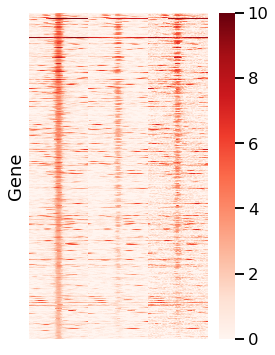

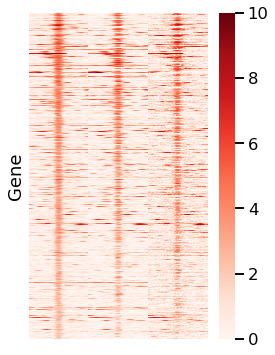

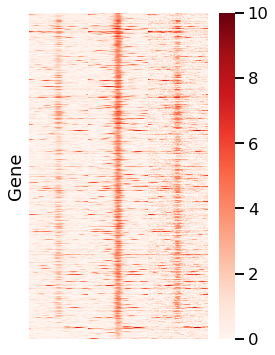

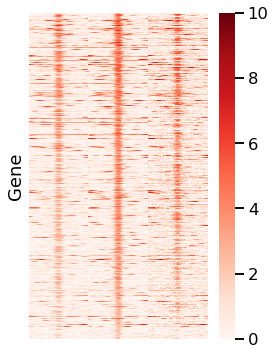

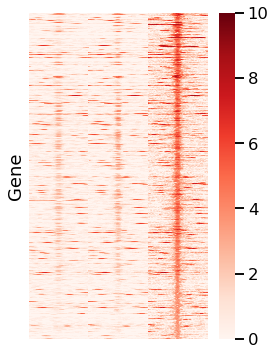

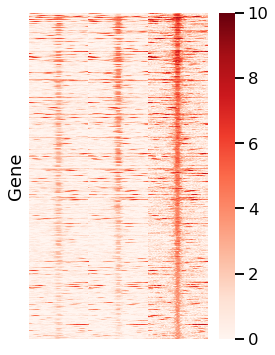

In [26]:
for i in np.sort(glob.glob('./peak_heatmaps/*ghist.txt')):
    figpath = i.replace('peak_heatmaps/', 'figures/atac_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    fig, ax = plt.subplots(figsize=(4,6))
    sns.heatmap(np.log2(df+1),
            cmap='Reds',
            # cbar_kws={'label':'Normalized\nTag Density'},
            vmax=10,
            xticklabels=0,
            yticklabels=0,
            ax=ax)
    
    print(figpath)
    plt.savefig(figpath)

In [12]:
mm_conv = 25.4

In [14]:
axs.flat

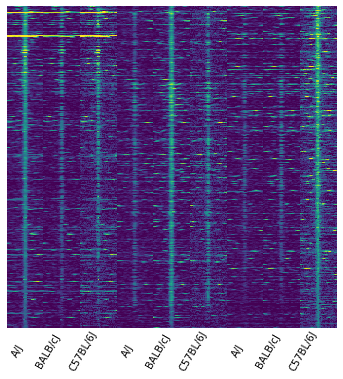

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(150/mm_conv, 150/mm_conv))
plt.subplots_adjust(wspace=0)
for i, ax in zip(np.sort(glob.glob('./peak_heatmaps/*intersection*ghist.txt')), axs.flat):
                 
                 
    figpath = i.replace('peak_heatmaps/', 'figures/atac_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    hm = sns.heatmap(np.log2(df+1),
            cmap='viridis',
            cbar=False,
            vmax=8,
            xticklabels=0,
            yticklabels=0,
            ax=ax)
    
    hm.set(ylabel=None)
    
    ax.text(1/6, -0.07,'A/J', horizontalalignment='right',
            verticalalignment='center',
            c='black',
            rotation=60,
            transform=ax.transAxes)
    ax.text(3/6, -0.07,'BALB/cJ', horizontalalignment='right',
            verticalalignment='center',
            c='black',
            rotation=60,
            transform=ax.transAxes)
    ax.text(5/6, -0.07,'C57BL/6J', horizontalalignment='right',
            verticalalignment='center',
            c='black',
            rotation=60,
            transform=ax.transAxes)
    # print(figpath)
    # plt.savefig(figpath)

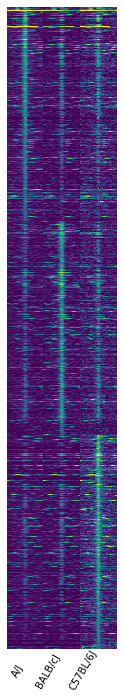

In [74]:
fig, axs = plt.subplots(3, 1, figsize=(50/mm_conv, 300/mm_conv))
plt.subplots_adjust(hspace=0)
for i, ax in zip(np.sort(glob.glob('./peak_heatmaps/*intersection*ghist.txt')), axs.flat):
                 
                 
    figpath = i.replace('peak_heatmaps/', 'figures/atac_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    hm = sns.heatmap(np.log2(df+1),
            cmap='viridis',
            cbar=False,
            vmax=8,
            xticklabels=0,
            yticklabels=0,
            ax=ax)
    
    hm.set(ylabel=None)
    
axs[2].text(1/6, -0.1,'A/J', horizontalalignment='right',
        verticalalignment='center',
        c='black',
        rotation=60,
        transform=ax.transAxes);
axs[2].text(3/6, -0.1,'BALB/cJ', horizontalalignment='right',
        verticalalignment='center',
        c='black',
        rotation=60,
        transform=ax.transAxes);
axs[2].text(5/6, -0.1,'C57BL/6J', horizontalalignment='right',
        verticalalignment='center',
        c='black',
        rotation=60,
        transform=ax.transAxes);

plt.savefig('./figures/atac_differential_stacked_viridis.pdf',
            dpi=500,
            bbox_inches='tight')

In [78]:
!wc -l ./peak_heatmaps/*intersection*ghist.txt

    594 ./peak_heatmaps/aj_intersection_3kb_ghist.txt
    791 ./peak_heatmaps/balbcj_intersection_3kb_ghist.txt
   1551 ./peak_heatmaps/c57bl6j_intersection_3kb_ghist.txt
   2936 total


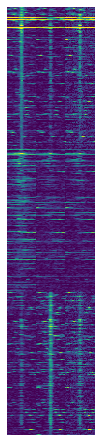

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(40/mm_conv, 200/mm_conv))
plt.subplots_adjust(hspace=0)
for i, ax in zip(np.sort(glob.glob('./peak_heatmaps/*intersection*ghist.txt')), axs.flat):
                 
                 
    figpath = i.replace('peak_heatmaps/', 'figures/atac_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    hm = sns.heatmap(np.log2(df+1),
            cmap='viridis',
            cbar=False,
            vmax=8,
            xticklabels=0,
            yticklabels=0,
            ax=ax)
    
    hm.set(ylabel=None)


plt.savefig('./figures/atac_differential_stacked_viridis.png',
            dpi=500,
            bbox_inches='tight')

# Try making with H3K27Ac

In [10]:
with open('./annotate_peak_heatmaps_h3k27ac.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./peak_heatmaps/*peaks.txt')):
        heatmap = peakfile.replace('_peaks.txt', '_3kb_h3k27ac_ghist.txt')
        call = ['annotatePeaks.pl', peakfile,
                'mm10 -size 3000 -hist 50 -ghist -d \\\n',
                h3k27acDirectory+'/merged_tagdirs/aj_Kupffer_H3K27Ac_young_control \\\n',
                h3k27acDirectory+'/merged_tagdirs/balbcj_Kupffer_H3K27Ac_young_control \\\n',
                h3k27acDirectory+'/merged_tagdirs/c57bl6j_Kupffer_H3K27Ac_young_control \\\n',
                '>', heatmap, '\n\n']
        f.write(' '.join(call))

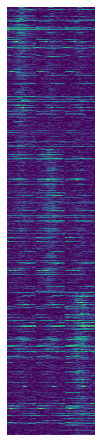

In [18]:
fig, axs = plt.subplots(3, 1, figsize=(40/mm_conv, 200/mm_conv))
plt.subplots_adjust(hspace=0)
for i, ax in zip(np.sort(glob.glob('./peak_heatmaps/*intersection*h3k27ac_ghist.txt')), axs.flat):
                 
                 
    figpath = i.replace('peak_heatmaps/', 'figures/atac_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    hm = sns.heatmap(np.log2(df+1),
            cmap='viridis',
            cbar=False,
            vmax=8,
            xticklabels=0,
            yticklabels=0,
            ax=ax)
    
    hm.set(ylabel=None)
    
# axs[2].text(1/6, -0.1,'A/J', horizontalalignment='right',
#         verticalalignment='center',
#         c='black',
#         rotation=60,
#         transform=ax.transAxes);
# axs[2].text(3/6, -0.1,'BALB/cJ', horizontalalignment='right',
#         verticalalignment='center',
#         c='black',
#         rotation=60,
#         transform=ax.transAxes);
# axs[2].text(5/6, -0.1,'C57BL/6J', horizontalalignment='right',
#         verticalalignment='center',
#         c='black',
#         rotation=60,
#         transform=ax.transAxes);

plt.savefig('./figures/h3k27ac_differential_stacked_viridis.png',
            dpi=500,
            bbox_inches='tight')

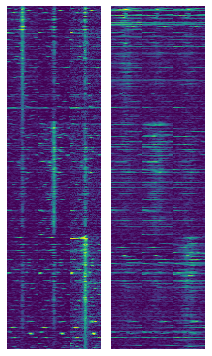

In [31]:
fig, axs = plt.subplots(3, 2, figsize=(90/mm_conv, 160/mm_conv))
plt.subplots_adjust(hspace=0, wspace=0.1)

for i, ax in zip(np.sort(glob.glob('./peak_heatmaps/*intersection_3kb_ghist.txt')), [axs[0,0], axs[1,0], axs[2,0] ]):
                 
                 
    figpath = i.replace('peak_heatmaps/', 'figures/atac_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    hm = sns.heatmap(np.log2(df+1),
            cmap='viridis',
            cbar=False,
            vmax=8,
            xticklabels=0,
            yticklabels=0,
            ax=ax)
    
    hm.set(ylabel=None)
    
    
for i, ax in zip(np.sort(glob.glob('./peak_heatmaps/*intersection*h3k27ac_ghist.txt')), [axs[0,1], axs[1,1], axs[2,1]]):                              
    figpath = i.replace('peak_heatmaps/', 'figures/atac_heatmap_')
    figpath = figpath.replace('.txt', '.png')
    
    df = pd.read_csv(i,
                 sep='\t',
                 index_col=0)
    
    hm = sns.heatmap(np.log2(df+1),
                cmap='viridis',
                cbar=False,
                vmax=8,
                xticklabels=0,
                yticklabels=0,
                ax=ax)

    hm.set(ylabel=None)

